In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from train import create_model, create_criterion, evaluate
from dataset import TrainData, TrainDataset

In [2]:
input_dir = "/storage/kaggle/quickdraw"
model_type = "cnn"
image_size = 32
batch_size = 256
test_size = 0.1
train_on_unrecognized = True
num_category_shards = 5
category_shard = 0
num_categories = 340 // num_category_shards
num_workers = 8
pin_memory = True
use_dummy_image = False

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
model = create_model(model_type, input_size=image_size, num_classes=num_categories)
model.load_state_dict(torch.load("/storage/models/quickdraw/test/model.pth", map_location=device))

In [5]:
train_data = TrainData(
    input_dir,
    shard=0,
    test_size=test_size,
    train_on_unrecognized=train_on_unrecognized,
    num_category_shards=num_category_shards,
    category_shard=category_shard)

Reading data file '/storage/kaggle/quickdraw/train_simplified_shards/shard-0.npz'
Loaded 994325 samples
Using the category range [0,68)
Time to load data of shard 0: 0:00:27.168595


In [6]:
val_set = TrainDataset(train_data.val_set_df, image_size, use_dummy_image)
val_set_data_loader = \
    DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

In [7]:
criterion = create_criterion("cce", num_categories)

In [8]:
loss_avg, mapk_avg, accuracy_top1_avg, accuracy_top3_avg, accuracy_top5_avg, accuracy_top10_avg = \
    evaluate(model, val_set_data_loader, criterion, 3)

In [9]:
print(
    "loss: {:.3f}, map@3: {:.3f}, acc@1: {:.3f}, acc@3: {:.3f}, acc@5: {:.3f}, acc@10: {:.3f}"
    .format(loss_avg, mapk_avg, accuracy_top1_avg, accuracy_top3_avg, accuracy_top5_avg, accuracy_top10_avg))

loss: 0.575, map@3: 0.889, acc@1: 0.846, acc@3: 0.939, acc@5: 0.957, acc@10: 0.972


In [10]:
val_set_data_loader_iter = iter(val_set_data_loader)

In [11]:
batch = next(val_set_data_loader_iter)

images, categories = \
    batch[0].to(device, non_blocking=True), \
    batch[1].to(device, non_blocking=True)

In [12]:
prediction_logits = model(images)
predictions = F.softmax(prediction_logits, dim=1)

In [13]:
prediction_scores, prediction_categories = predictions.topk(3, dim=1, sorted=True)

In [14]:
print(prediction_scores[:10, 0])

tensor([0.7108, 1.0000, 0.9960, 0.9998, 0.8685, 0.9865, 1.0000, 0.9916, 0.7663,
        0.9828], device='cuda:0', grad_fn=<SelectBackward>)


In [15]:
print(np.array(train_data.categories)[prediction_categories[:10, 0]])

[32 65  5 37 33 33 37 29 50 65]


In [16]:
print(prediction_scores[:, 0].mean())
print(prediction_scores[:, 0].std())
print(prediction_scores[:, 0].min())
print(prediction_scores[:, 0].max())

tensor(0.8316, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.2340, device='cuda:0', grad_fn=<StdBackward0>)
tensor(0.1256, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)


In [17]:
print(prediction_scores[categories == 0][:, 0].mean())
print(prediction_scores[categories == 0][:, 0].std())
print(prediction_scores[categories == 0][:, 0].min())
print(prediction_scores[categories == 0][:, 0].max())

tensor(0.9923, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0103, device='cuda:0', grad_fn=<StdBackward0>)
tensor(0.9746, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)


In [18]:
confusion = np.zeros((num_categories, num_categories), dtype=np.float32)
for bpc, bc in zip(prediction_categories[:, 0], categories):
    confusion[bpc, bc] += 1

for c in range(num_categories):
    category_count = (prediction_categories[:, 0] == c).sum().item()
    if category_count != 0:
        confusion[c, :] /= category_count

In [19]:
print(confusion.mean())
print(confusion.std())
print(confusion.min())
print(confusion.max())

0.014489619
0.10628839
0.0
1.0


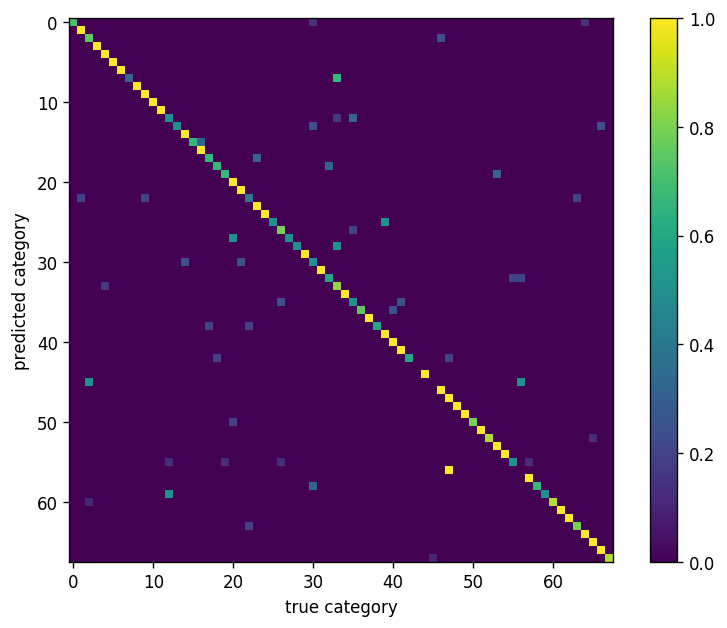

In [20]:
plt.figure(num=None, figsize=(8, 6), dpi=120, facecolor="w", edgecolor="k")
plt.imshow(confusion, vmin=0.0, vmax=1.0)
plt.xlabel("true category")
plt.ylabel("predicted category")
plt.colorbar()